<a href="https://colab.research.google.com/github/Mervvick/AI_ImageSegmentation_Pro/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%7C_%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9_%7C_%D0%94%D0%97_Pro_%7C_%D0%A3%D0%98%D0%98%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. На основе учебного ноутбука проведите финальную подготовку данных. Измените количество сегментирующих классов с `16` на `7`:
  - 0_класс - FLOOR
  - 1_класс - CEILING
  - 2_класс - WALL
  - 3_класс - APERTURE, DOOR, WINDOW
  - 4_класс - COLUMN, RAILINGS, LADDER
  - 5_класс - INVENTORY
  - 6_класс - LAMP, WIRE, BEAM, EXTERNAL, BATTERY,
PEOPLE

2. Изучите внимательно особенности `U-net`, определите в чем принципиальное отличие  `U-net `  и   `simpleUnet` из учебного ноутбука.

3. Доработайте `simpleUnet` с учетом особенностей `U-net `. Обучите модель на 100 эпохах и визуализируйте результат.

**Важно!**

Многие эксперименты могут приводить к переполнению ОЗУ в вашем ноутбуке и сброса кода обучения.

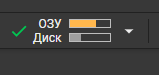

Для предотвращения переполнения ОЗУ может помочь библиотека `gc`. Вставьте строчку `gc.collect()` в цикл ваших экспериментов для сбора и удаления временных данных (кеш).

Перед выполнением задания, пожалуйста, запустите ячейку `Подготовка` ниже:

## Подготовка

### Импорт библиотек

In [1]:
 # Импортируем модели keras: Model
from tensorflow.keras.models import Model

 # Импортируем стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D

# Импортируем оптимизатор Adam
from tensorflow.keras.optimizers import Adam

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt

# Импортируем модуль image для работы с изображениями
from tensorflow.keras.preprocessing import image

# Импортируем библиотеку numpy
import numpy as np

# Импортируем методделения выборки
from sklearn.model_selection import train_test_split

# загрузка файлов по HTML ссылке
import gdown

# Для работы с файлами
import os

# Для генерации случайных чисел
import random

import time

# импортируем модель Image для работы с изображениями
from PIL import Image

# очистка ОЗУ
import gc

### Загрузка датасета

грузим и распаковываем архив картинок

In [2]:
# Загрузка датасета из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip', None, quiet=False)
#gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_512x384.zip', None, quiet=False)

!unzip -q 'construction_256x192.zip' # распоковываем архив

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip
To: /content/construction_256x192.zip
100%|██████████| 214M/214M [00:20<00:00, 10.4MB/s]


### Предварительная подготовка данных


In [3]:
# Глобальные параметры

IMG_WIDTH = 192               # Ширина картинки
IMG_HEIGHT = 256             # Высота картинки
NUM_CLASSES = 16              # Задаем количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки

Загрузим оригинальные изображения (код из лекции):

In [4]:
train_images = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_images = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time()  # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_images.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/original',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в обучающей выборке
print ('Количество изображений: ', len(train_images))

cur_time = time.time() # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(VAL_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_images.append(image.load_img(os.path.join(VAL_DIRECTORY+'/original',filename),
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочной выборке
print ('Количество изображений: ', len(val_images))

Обучающая выборка загружена. Время загрузки: 0.39c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.02c
Количество изображений:  100


Загрузим сегментированные изображения (код из лекции):

In [5]:
train_segments = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_segments.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/segment',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в обучающем наборе сегментированных изображений
print ('Количество изображений: ', len(train_segments))

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(VAL_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_segments.append(image.load_img(os.path.join(VAL_DIRECTORY+'/segment',filename),
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочном наборе сегментированных изображений
print ('Количество изображений: ', len(val_segments))

Обучающая выборка загружена. Время загрузки: 0.32c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.02c
Количество изображений:  100


## Решение

In [6]:
# Ваше решение
FLOOR = (100, 100, 100)
CEILING = (0, 0, 100)
WALL = (0, 100, 0)
COLUMN = (100, 0, 0)
APERTURE = (0, 100, 100)
DOOR = (100, 0, 100)
WINDOW = (100, 100, 0)
EXTERNAL = (200, 200, 200)
RAILINGS = (0, 200, 0)
BATTERY = (200, 0, 0)
PEOPLE = (0, 200, 200)
LADDER = (0, 0, 200)
INVENTORY = (200, 0, 200)
LAMP = (200, 200, 0)
WIRE = (0, 100, 200)
BEAM = (100, 0, 200)

In [7]:
CLASS_LABELS = (FLOOR, CEILING, WALL, COLUMN, APERTURE, DOOR, WINDOW, EXTERNAL, RAILINGS, BATTERY, PEOPLE, LADDER, INVENTORY, LAMP, WIRE, BEAM)

In [8]:
def rgb_to_labels(image_list):

    result = []

    for d in image_list:
        sample = np.array(d)
        y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype='uint8')

        for i, cl in enumerate(CLASS_LABELS):
            y[np.where(np.all(sample == CLASS_LABELS[i], axis=-1))] = i

        result.append(y)

    return np.array(result)

In [15]:
def labels_to_rgb(image_list):

    result = []
    for y in image_list:
        temp = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype='uint8')
        for i, cl in enumerate(CLASS_LABELS):
            temp[np.where(np.all(y==i, axis=-1))] = CLASS_LABELS[i]
        result.append(temp)

    return np.array(result)

In [9]:
x_train = []
x_val = []

for img in train_images:
  x_train.append(image.img_to_array(img))
x_train = np.array(x_train)

for img in val_images:
  x_val.append(image.img_to_array(img))
x_val = np.array(x_val)

print(x_train.shape)
print(x_val.shape)

(1900, 192, 256, 3)
(100, 192, 256, 3)


In [10]:
y_train = []
y_val = []

y_train = rgb_to_labels(train_segments)
y_val = rgb_to_labels(val_segments)

print(y_train.shape)
print(y_val.shape)

(1900, 192, 256, 1)
(100, 192, 256, 1)


0_класс - FLOOR

1_класс - CEILING

2_класс - WALL

3_класс - APERTURE, DOOR, WINDOW

4_класс - COLUMN, RAILINGS, LADDER

5_класс - INVENTORY

6_класс - LAMP, WIRE, BEAM, EXTERNAL, BATTERY, PEOPLE

In [11]:
y_train_7 = y_train.copy()
y_val_7 = y_val.copy()

mask = [[FLOOR],
        [CEILING],
        [WALL],
        [APERTURE, DOOR, WINDOW],
        [COLUMN, RAILINGS, LADDER],
        [INVENTORY],
        [LAMP, WIRE, BEAM, EXTERNAL, BATTERY, PEOPLE]]

print(y_train.max())
print(y_val.max())

for x, m in enumerate(mask):
  for cl in m:
    y_train_7[y_train == CLASS_LABELS.index(cl)] = x
    y_val_7[y_val == CLASS_LABELS.index(cl)] = x

print(y_train_7.max())
print(y_val_7.max())

15
15
6
6


## Модель

Доработать модель

In [12]:
NUM_CLASSES = 7
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

In [13]:
def simple_unet_2(class_count,
                  input_shape
                  ):

    img_input = Input(input_shape)

    # DOWN 1
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    down_1_out = Activation('relu')(x)

    x = MaxPooling2D(4)(down_1_out)

    # DOWN 2
    x = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    down_2_out = Activation('relu')(x)

    x = MaxPooling2D(4)(down_2_out)

    # UP 1
    x = Conv2DTranspose(64, (4, 4), strides=(4, 4), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, down_2_out])

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(32, (4, 4), strides=(4, 4), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, down_1_out])

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(class_count,(3,3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    return model

In [14]:
model = simple_unet_2(NUM_CLASSES, input_shape)
model.summary()
model.compile(optimizer=Adam(0.0001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])
gc.collect()
history = model.fit(x_train,
                    y_train_7,
                    batch_size = 32,
                    epochs = 100,
                    verbose = 1,
                    validation_data = (x_val, y_val_7)
                    )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 192, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 192, 256, 32  128        ['block1_conv1[0][0]']           
 alization)                     )                                                             

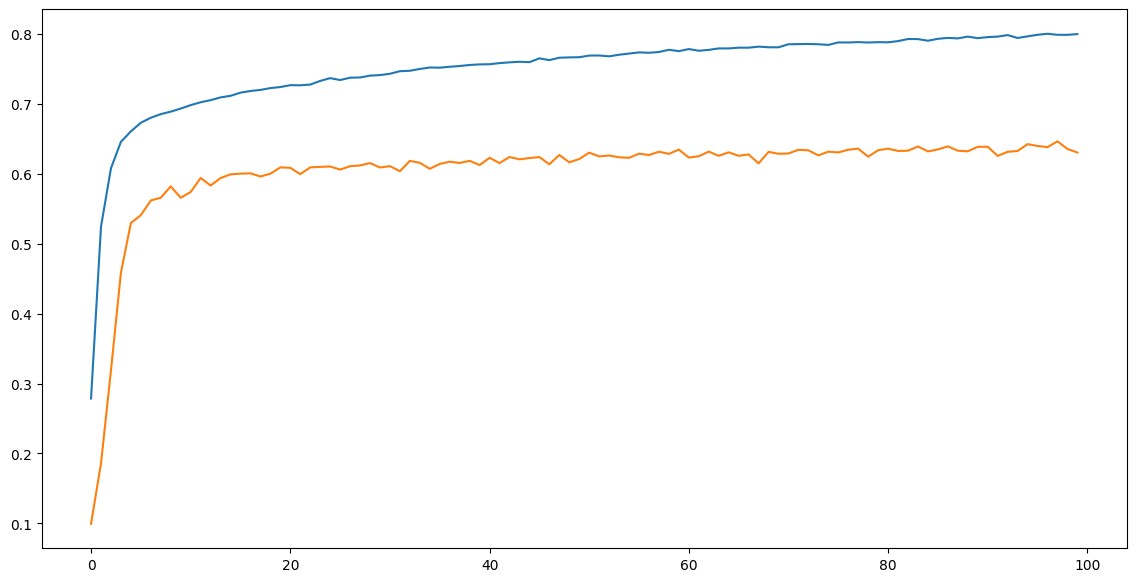

In [16]:
plt.figure(figsize=(14,7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

In [17]:
def process_images(model,        # обученная модель
                   count = 1     # количество случайных картинок для сегментации
                   ):

    # Генерация случайного списка индексов в количестве count между (0, len(x_val)
    indexes = np.random.randint(0, len(x_val), count)

    # Вычисление предсказания сети для картинок с отобранными индексами
    predict = np.argmax(model.predict(x_val[indexes]), axis=-1)

    # Подготовка цветов классов для отрисовки предсказания
    orig = labels_to_rgb(predict[..., None])
    fig, axs = plt.subplots(3, count, figsize=(25, 15))

    # Отрисовка результата работы модели
    for i in range(count):
        # Отображение на графике в первой линии предсказания модели
        axs[0, 0].set_title('Результат работы модели:')
        axs[0, i].imshow(orig[i])
        axs[0, i].axis('off')

        # Отображение на графике во второй линии сегментированного изображения из y_val
        axs[1, 0].set_title('Оригинальное сегментированное')
        axs[1, i].imshow(val_segments[indexes[i]])
        axs[1 ,i].axis('off')

        # Отображение на графике в третьей линии оригинального изображения
        axs[2, 0].set_title('Оригинальное изображение')
        axs[2, i].imshow(val_images[indexes[i]])
        axs[2 ,i].axis('off')

    plt.show()

1/1 [==============================] - 0s 56ms/step


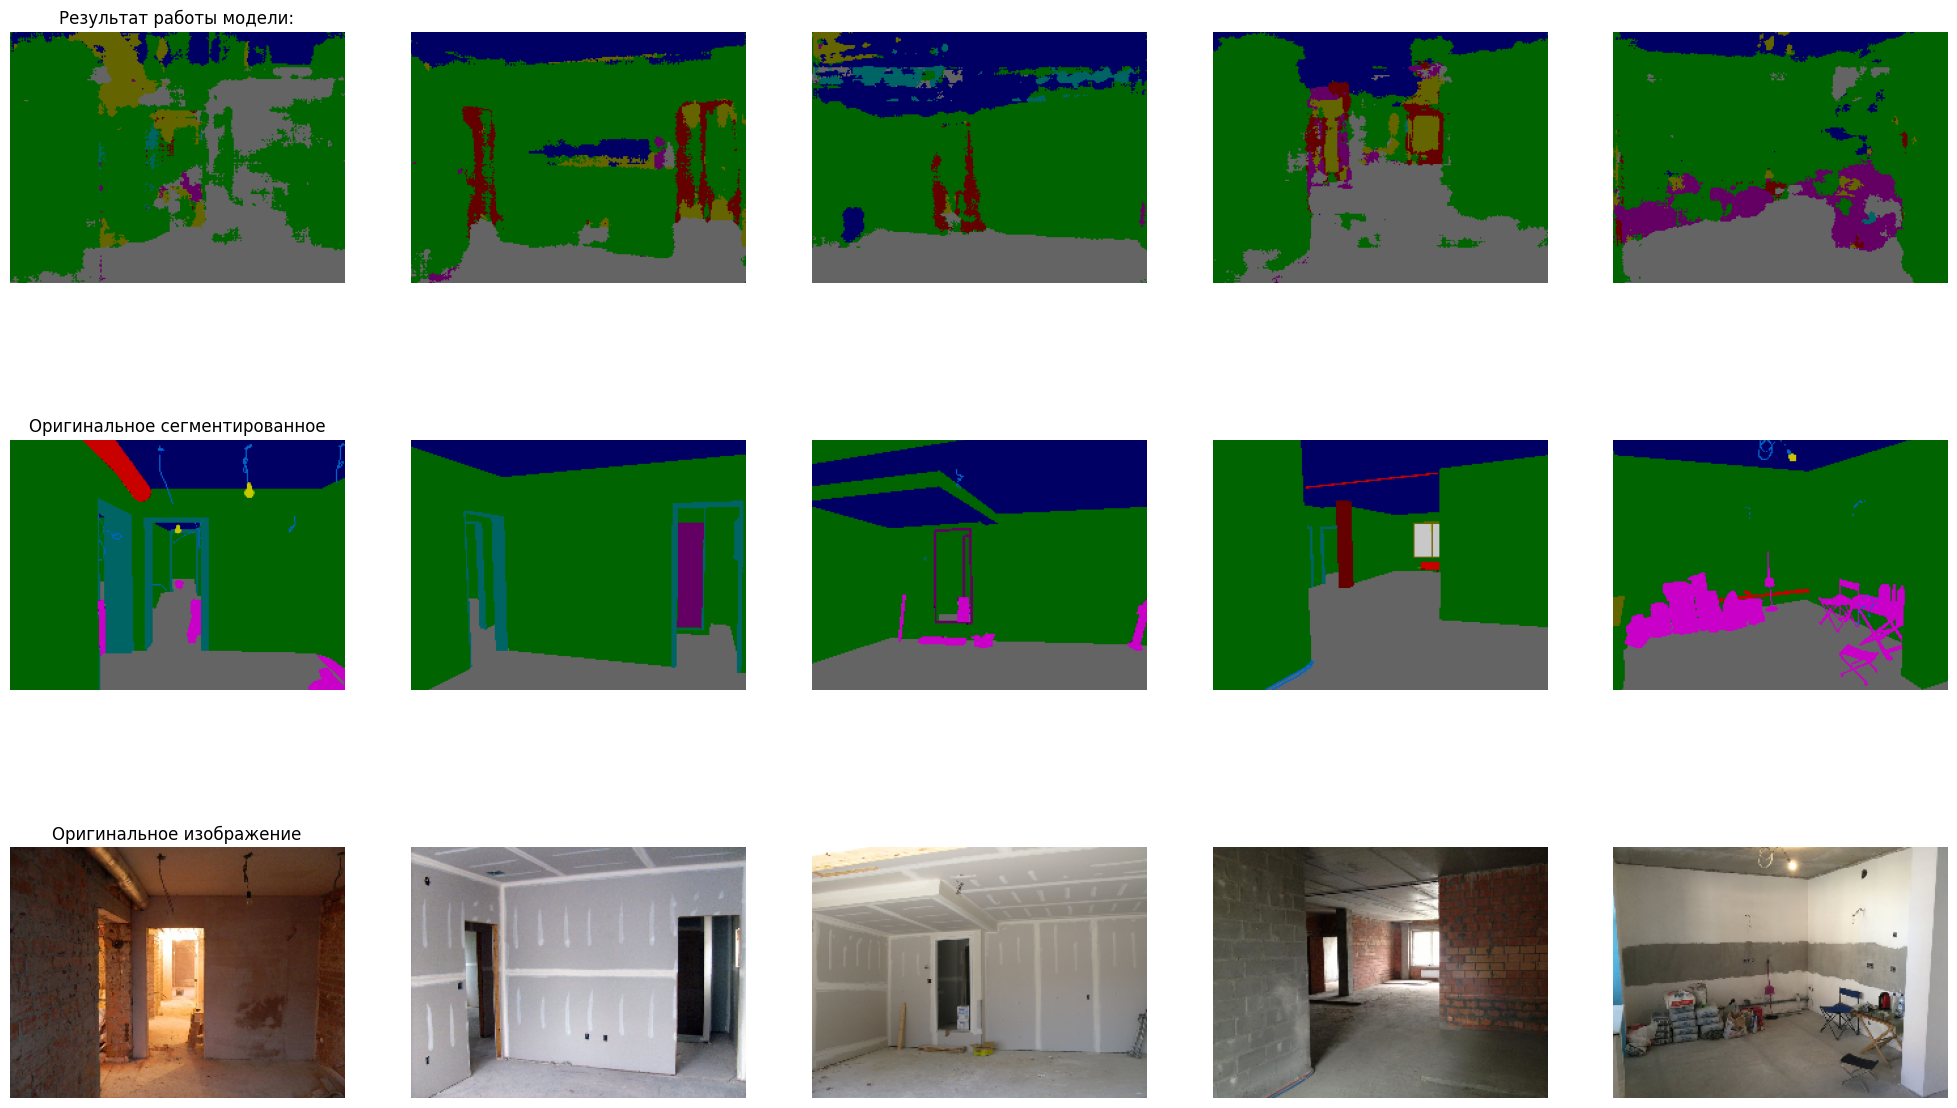

In [21]:
process_images(model, 5)